In [72]:
import numpy as np
import statsmodels.tsa.stattools as stm
import scipy.stats as sc
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans, DBSCAN
import findspark
from pyspark.sql import SparkSession

In [73]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [74]:
findspark.init()
spark = SparkSession.builder.appName("Ownership").getOrCreate()

In [75]:
ownership_data = spark.read.csv("../../data/clean_data/clean_car_ownership.csv", header=True, inferSchema=True)
sales_data = spark.read.csv("../../data/clean_data/clean_car_sales.csv", header=True, inferSchema=True)

ownership_data = ownership_data.withColumnRenamed('Annual Income', 'Annual_Income')
ownership_data = ownership_data.withColumnRenamed('Years of Employment', 'Years_of_Employment')
ownership_data = ownership_data.withColumnRenamed('Credit Score', 'Credit_Score')
ownership_data = ownership_data.withColumnRenamed('Finance Status', 'Finance_Status')
ownership_data = ownership_data.withColumnRenamed('Number of Children', 'Number_of_Children')

sales_data = sales_data.withColumnRenamed('Annual Income', 'Annual_Income')
sales_data = sales_data.withColumnRenamed('Body Style', 'Body_Style')
sales_data = sales_data.withColumnRenamed('Price ($)', 'Price')

ownership_data.createOrReplaceTempView("ownership")
sales_data.createOrReplaceTempView("sales")

In [76]:
def sql_to_df(command: str) -> pd.DataFrame:
    return spark.sql(command).toPandas()

In [77]:
ownership_data.show()

+---+------------+------------------+------------+-------------------+--------------+---+------------------+
|_c0|  Occupation|     Annual_Income|Credit_Score|Years_of_Employment|Finance_Status|Car|Number_of_Children|
+---+------------+------------------+------------+-------------------+--------------+---+------------------+
|  0|     Teacher|           52800.0|         750|                 10|          Good|Yes|                 2|
|  1|    Engineer| 79199.99999999999|         800|                  8|          Good|Yes|                 1|
|  2|       Nurse|           33000.0|         650|                  5|          Fair| No|                 0|
|  3|      Doctor|          105600.0|         900|                 12|     Excellent|Yes|                 3|
|  4| Businessman|          132000.0|         700|                 15|          Good|Yes|                 2|
|  5|    Engineer|           66000.0|         750|                  6|          Fair| No|                 1|
|  6|     Teacher| 

In [78]:
filtered = sql_to_df('''select Occupation, count(Car) as Ownership_Count, Car from ownership
                        group by Occupation, Car
                        order by Ownership_Count
                     ''')

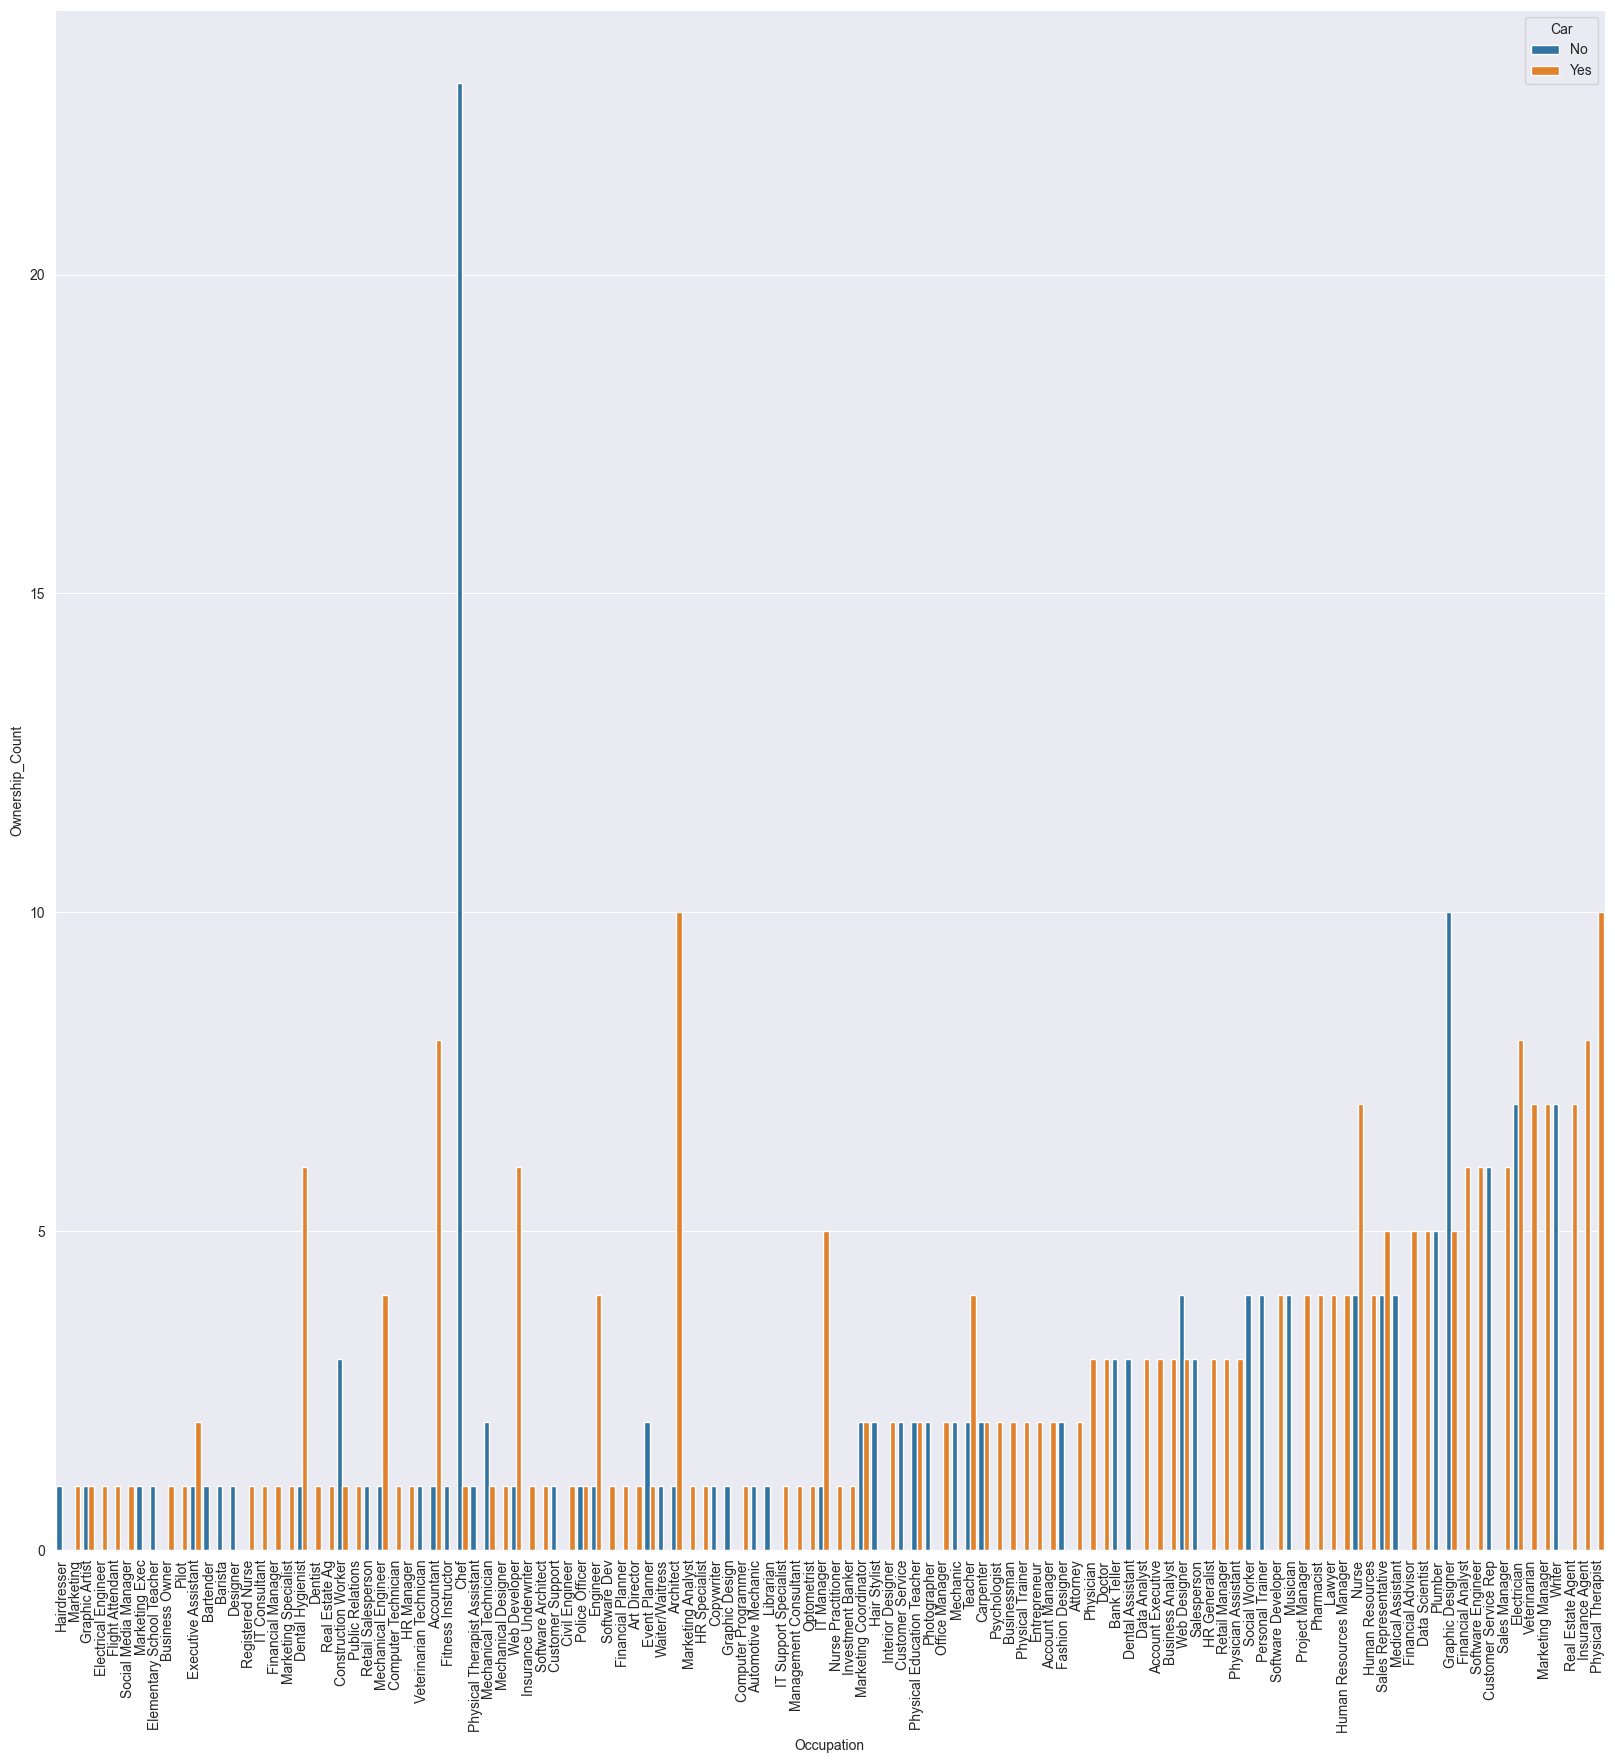

In [79]:
plt.figure(figsize=(20,20))
sb.barplot(data=filtered, x="Occupation", y="Ownership_Count", hue="Car")
plt.xticks(rotation=90)
plt.show()

In [80]:
explode = (0.1, 0, 0, 0.2, 0, 0, 0)
filtered = sql_to_df('''select Finance_status, count(Finance_Status) as Finance_Status_Counts from ownership
                        group by Finance_status
                        order by Finance_Status_Counts
                        ''')

filtered['Finance_Status_Counts'] = filtered['Finance_Status_Counts'].apply(lambda x: x / filtered['Finance_Status_Counts'].sum() * 100)
filtered

,Finance_status,Finance_Status_Counts
0,Poor,1.010101
1,Excellent,2.777778
2,Good,3.282828
3,Unknown,3.282828
4,Fair,3.535354
5,Unstable,18.181818
6,Stable,67.929293


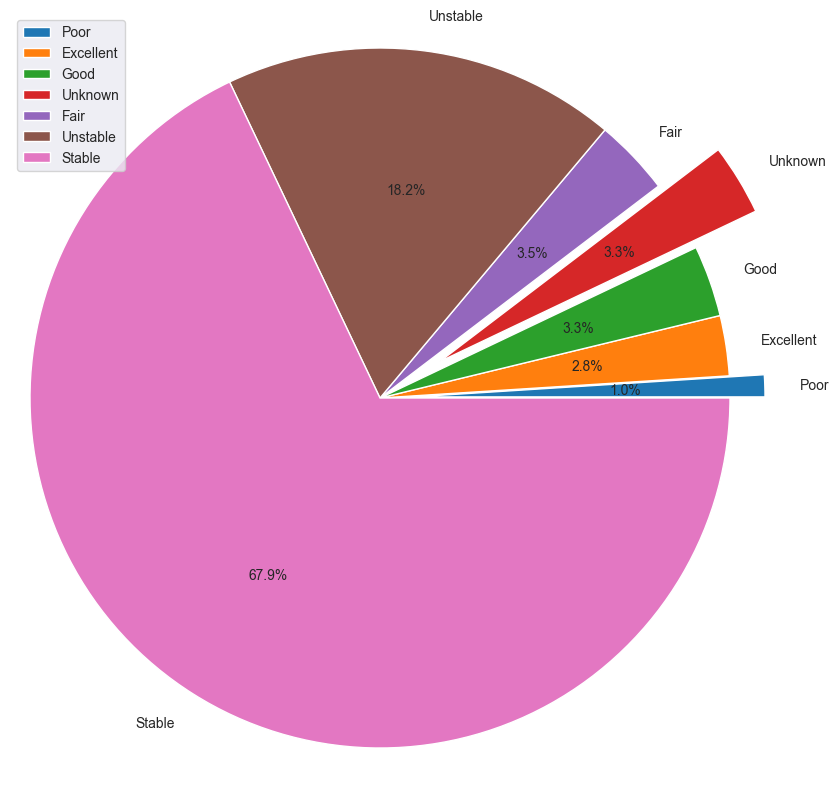

In [81]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Finance_Status_Counts'] ,explode=explode, labels=filtered['Finance_status'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [82]:
filtered = sql_to_df('''select Finance_status, Car, avg(Years_of_Employment) as Years_od_Employment_Average from ownership
                        group by Finance_status, Car
                        order by Years_od_Employment_Average''')
filtered

,Finance_status,Car,Years_od_Employment_Average
0,Unstable,No,1.611940
1,Poor,No,1.750000
2,Good,No,2.333333
3,Unstable,Yes,2.400000
4,Excellent,No,2.666667
5,Unknown,No,2.700000
6,Fair,No,3.000000
7,Stable,No,3.265306
8,Stable,Yes,5.377273
9,Unknown,Yes,6.000000


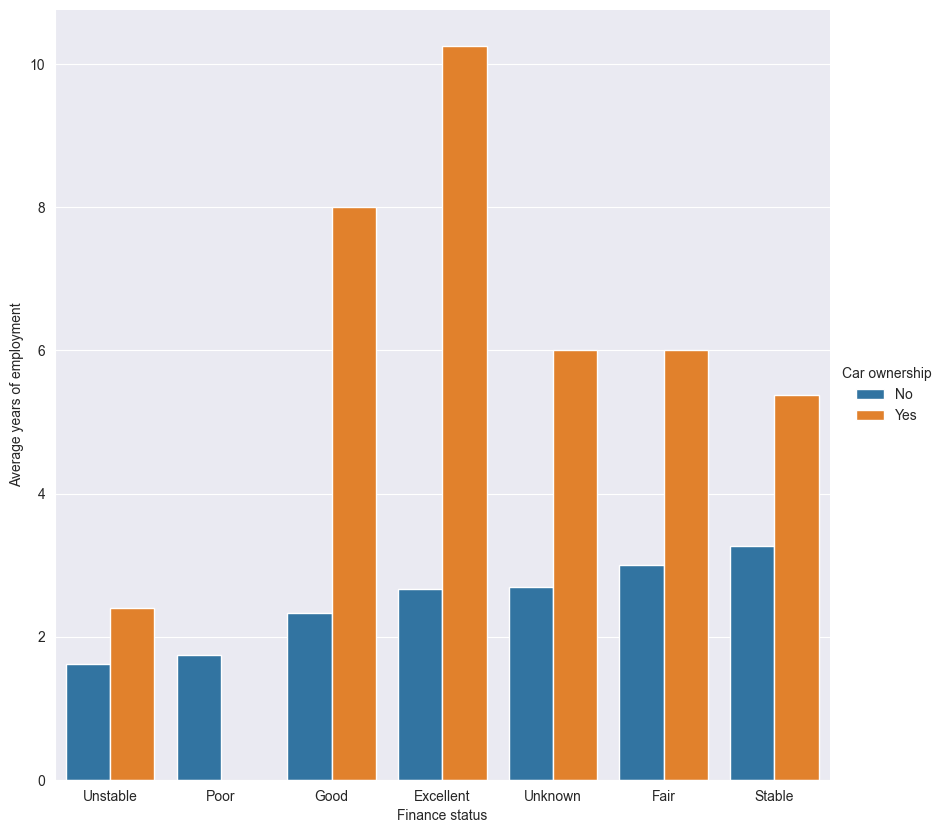

In [83]:
plt.figure(figsize=(10, 10))
ax = sb.barplot(x='Finance_status', y='Years_od_Employment_Average', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Average years of employment', xlabel='Finance status')
ax.legend(title='Car ownership')
sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

In [84]:
filtered = sql_to_df('''select Car,  count(Car) as Ownership_count, Number_of_Children from ownership
                        group by Number_of_Children, Car
                        having Number_of_Children > -1
                        order by Number_of_Children asc
                        ''')
filtered

,Car,Ownership_count,Number_of_Children
0,No,38,0
1,Yes,74,0
2,No,32,1
3,Yes,68,1
4,No,25,2
5,Yes,62,2
6,Yes,9,3
7,No,8,3
8,No,1,4


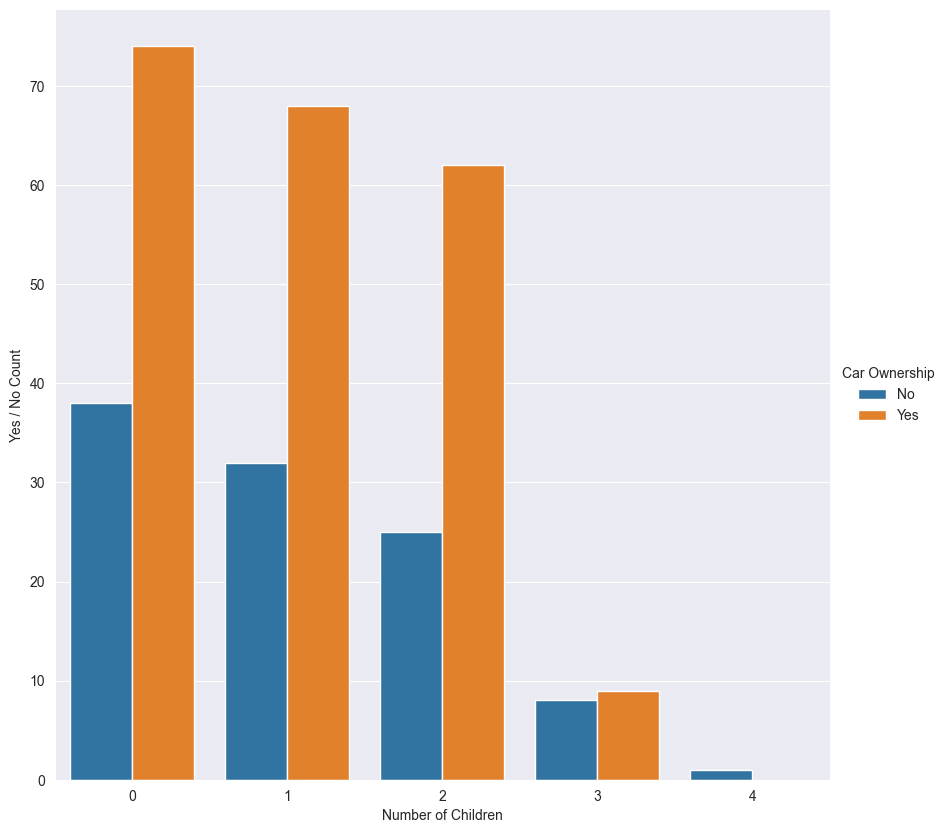

In [85]:
plt.figure(figsize=(10, 10))
ax = sb.barplot(x='Number_of_Children', y='Ownership_count', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Yes / No Count', xlabel='Number of Children')
ax.legend(title='Car Ownership')
sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

In [86]:
filtered = sql_to_df('''select Car, Annual_Income from ownership where Annual_Income < 66000''')
filtered

,Car,Annual_Income
0,Yes,52800.0
1,No,33000.0
2,Yes,46200.0
3,No,26400.0
4,Yes,7920.0
...,...,...
382,No,4620.0
383,Yes,6336.0
384,Yes,9240.0
385,No,4620.0


In [87]:
display(sql_to_df('''select count(Car) from ownership where Annual_Income > 66000 and Car == "No"'''))

,count(Car)
0,0


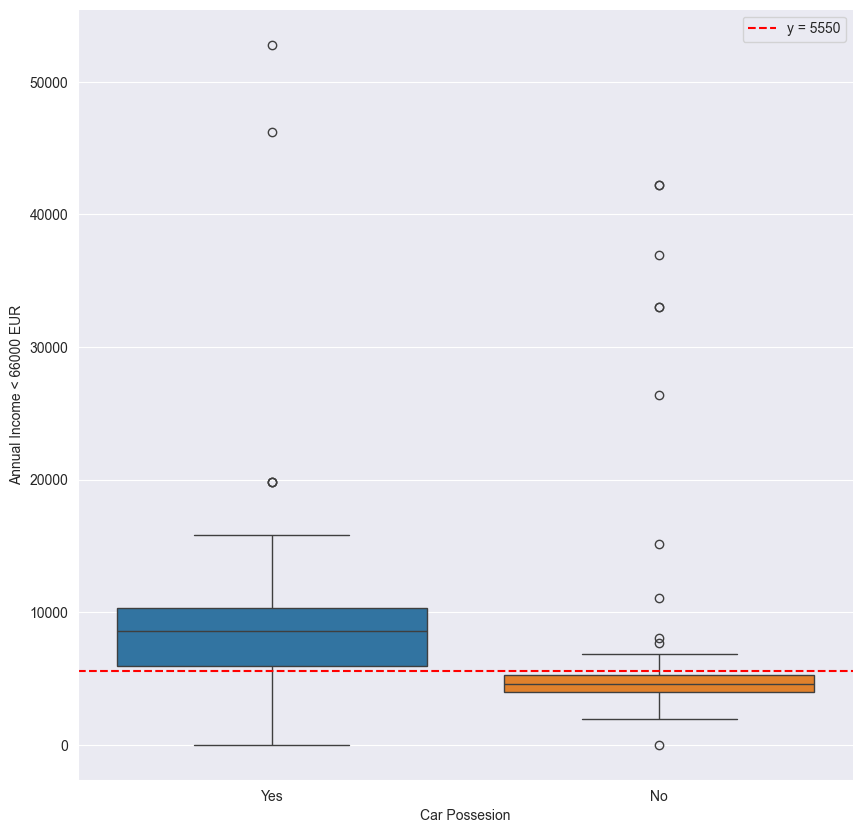

In [88]:
plt.figure(figsize=(10, 10))
ax = sb.boxplot(x='Car', y='Annual_Income', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Annual Income < 66000 EUR', xlabel='Car Possesion')
plt.axhline(y=5550, color='red', linestyle='--', label='y = 5550')
plt.legend()
plt.show()

In [89]:
sales_data.show()

+---+------------+--------+------+------------------+--------------------+----------+-------------+--------------------+------------+----------+-----+----------+----------+-------+-------------+
|_c0|      Car_id|    Date|Gender|     Annual_Income|         Dealer_Name|   Company|        Model|              Engine|Transmission|     Color|Price|Dealer_No |Body_Style|  Phone|Dealer_Region|
+---+------------+--------+------+------------------+--------------------+----------+-------------+--------------------+------------+----------+-----+----------+----------+-------+-------------+
|  0|C_CND_000001|1/2/2022|  Male|             148.5|Buddy Storbeck's ...|      Ford|   Expedition|DoubleÂ Overhead ...|        Auto|     Black|26000|06457-3834|       SUV|8264678|   Middletown|
|  1|C_CND_000002|1/2/2022|  Male|16279.999999999998|    C & M Motors Inc|     Dodge|      Durango|DoubleÂ Overhead ...|        Auto|     Black|19000|60504-7114|       SUV|6848189|       Aurora|
|  2|C_CND_000003|1/2/202

In [90]:
filtered = sql_to_df('''select Gender, count(Gender) as Gender_Count from sales
                        group by Gender''')
filtered['Gender_Count'] = filtered['Gender_Count'].apply(lambda x: x / filtered['Gender_Count'].sum() * 100)
filtered

,Gender,Gender_Count
0,Female,21.367021
1,Male,78.632979


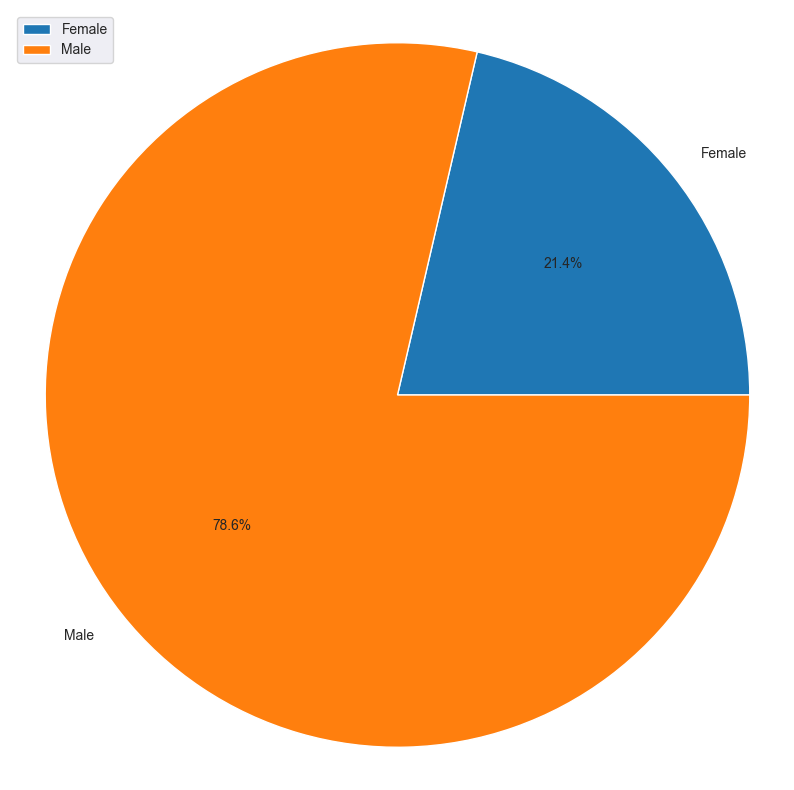

In [91]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Gender_Count'], labels=filtered['Gender'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [94]:
filtered = sql_to_df('''select Gender, Annual_Income, Price from sales''')
filtered

,Gender,Annual_Income,Price
0,Male,148.5,26000
1,Male,16280.0,19000
2,Male,11385.0,31500
3,Male,148.5,14000
4,Male,16115.0,24500
...,...,...,...
23901,Male,148.5,12000
23902,Female,9900.0,16000
23903,Male,7755.0,21000
23904,Male,148.5,31000


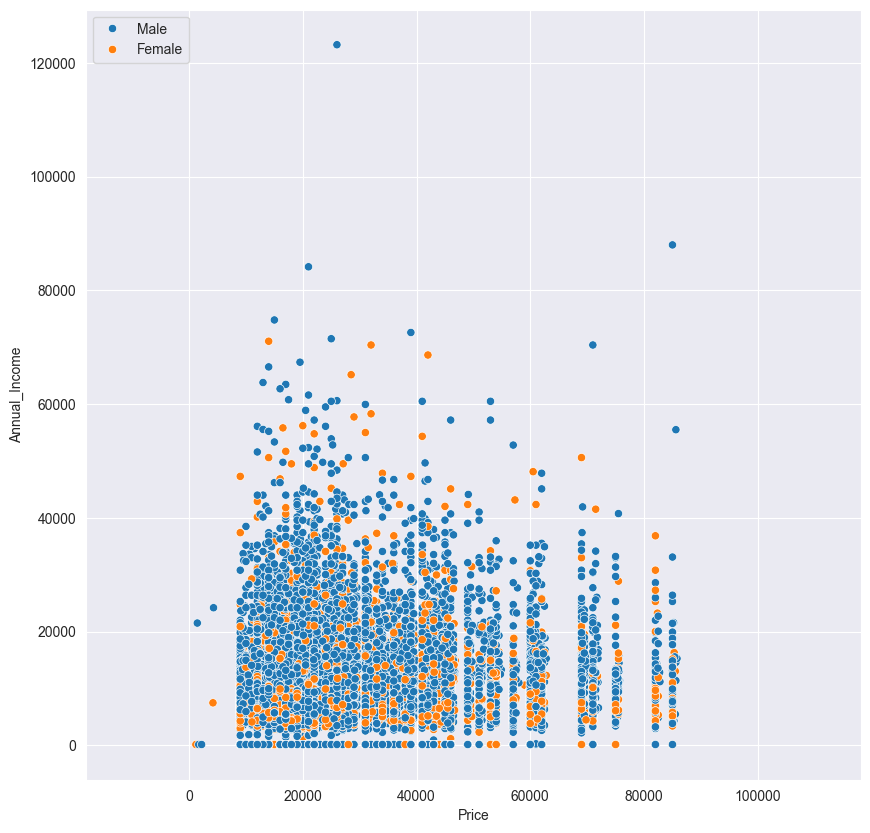

In [99]:
plt.figure(figsize=(10,10))
sb.scatterplot(data=filtered, x='Price', y='Annual_Income', hue='Gender')
plt.axis('equal')
plt.xlim(0, 100000)
plt.legend(loc='upper left')

In [93]:
# spark.stop()